# Loan returning prediction Project

## Objectives

#### Loading a historical dataset from previous loan applications, cleaning the data, and applying different classification algorithms on the data:

- **k-Nearest Neighbour**
- **Decision Tree**
- **Support Vector Machine**
- **Logistic Regression**

#### The results is reported as the accuracy of each classifier, using the following metrics when these are applicable:

- **Jaccard index**
- **F1-score**
- **LogLoass**

## About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


In [1]:
# Importing libraries
import itertools
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Reading and Exploring Data


In [2]:
# Reading training data
train_df = pd.read_csv('loan_train.csv', parse_dates=['effective_date', 'due_date'])

print(f'Train data\'s shape - {train_df.shape}')
train_df.head()

Train data's shape - (346, 10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [3]:
# Let's look at the types of the traing data
train_df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dtype: object

In [4]:
# Let's have a look at our testing data
test_df = pd.read_csv('loan_test.csv', parse_dates=['effective_date', 'due_date'])

print(f'Test data\'s shape - {test_df.shape}')
test_df.head()

Test data's shape - (54, 10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [5]:
# Let's look at the types of the testing data
test_df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dtype: object

In [6]:
# Let's rename columns names by changing uppercase to lowercace and replacing ':'
columns_names = {i: i.lower().replace(': ', '_') for i in train_df.columns}
train_df.rename(columns=columns_names, inplace=True)
test_df.rename(columns=columns_names, inplace=True)
train_df.head()

,unnamed_0,unnamed_0.1,loan_status,principal,terms,effective_date,due_date,age,education,gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [7]:
test_df.head()

,unnamed_0,unnamed_0.1,loan_status,principal,terms,effective_date,due_date,age,education,gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [8]:
# It seems that columns unnamed_0 and unnamed_0.1 have the same values. Let's check it
all(train_df.unnamed_0 == train_df['unnamed_0.1'])

True

In [9]:
# Let's drop unnamed_0.1 column because we won't need it
train_df.drop(columns='unnamed_0.1', inplace=True)
test_df.drop(columns='unnamed_0.1', inplace=True)
train_df.head()

,unnamed_0,loan_status,principal,terms,effective_date,due_date,age,education,gender
0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [10]:
# Now let's see if there are any missing values in the traing data
missing = train_df.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

There aren't any missing values in our training dataset.

In [11]:
# Let's make sure we don't have any duplicates
train_df.duplicated().sum()

0

## Data visualization and pre-processing


In [12]:
# Let’s see how many of each class is in our training data set
train_df.loan_status.value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection

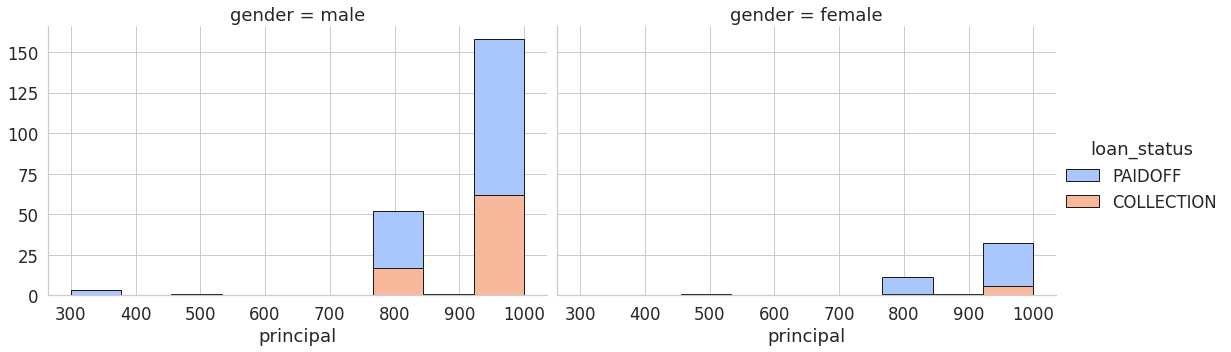

In [13]:
# Let's plot some columns to underestand data better
bins = np.linspace(train_df.principal.min(), train_df.principal.max(), 10)
g = sns.FacetGrid(train_df, col='gender', hue='loan_status', palette='coolwarm', height=5, aspect=1.5)
g.map(plt.hist, 'principal', bins=bins, ec='k')
g.add_legend();

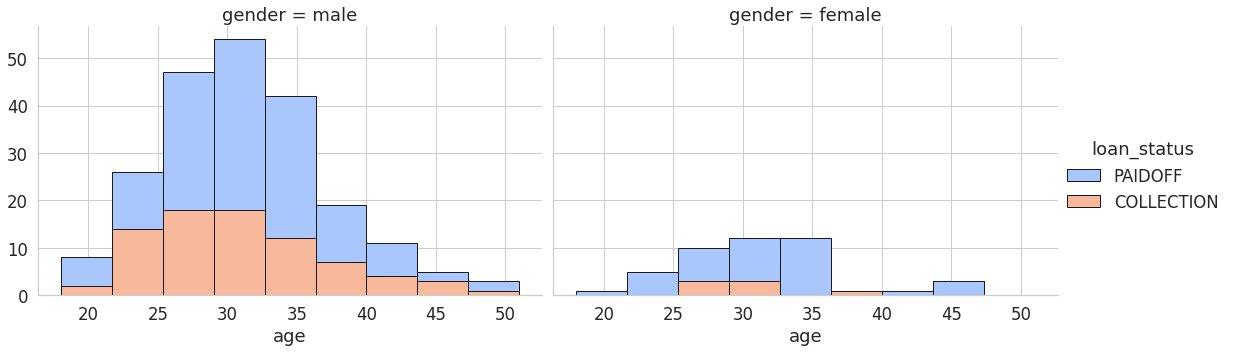

In [14]:
bins = np.linspace(train_df.age.min(), train_df.age.max(), 10)
g = sns.FacetGrid(train_df, col='gender', hue='loan_status', palette="coolwarm", height=5, aspect=1.5)
g.map(plt.hist, 'age', bins=bins, ec='k')
g.add_legend();

### Pre-processing:  Feature selection/extraction


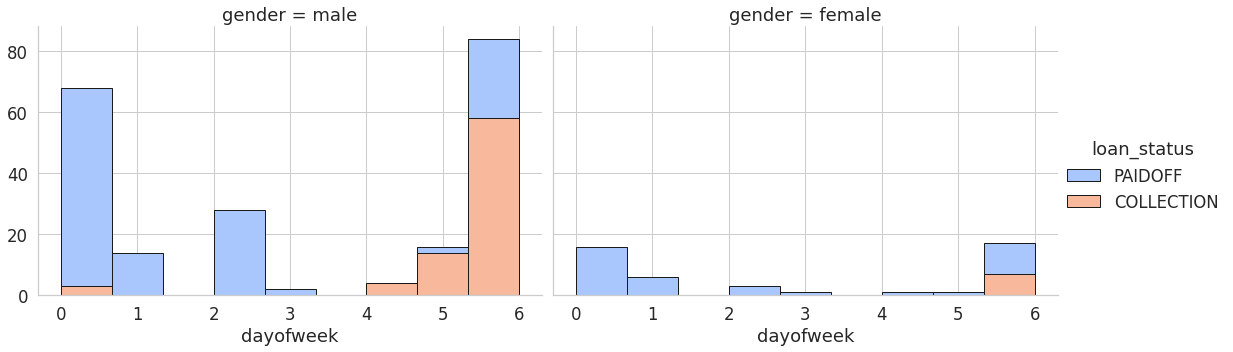

In [15]:
# Let's add a new column with the day of a week when the loan got originated
train_df['dayofweek'] = train_df['effective_date'].dt.dayofweek
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

# Let's look at the day of the week people get the loan
bins = np.linspace(train_df.dayofweek.min(), train_df.dayofweek.max(), 10)
g = sns.FacetGrid(train_df, col='gender', hue='loan_status', palette='coolwarm', height=5, aspect=1.5)
g.map(plt.hist, 'dayofweek', bins=bins, ec='k')
g.add_legend();

We see that many people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4.


In [16]:
train_df['weekend'] = np.where(train_df.dayofweek > 3, 1, 0)
test_df['weekend'] = np.where(test_df.dayofweek > 3, 1, 0)
train_df.head()

,unnamed_0,loan_status,principal,terms,effective_date,due_date,age,education,gender,dayofweek,weekend
0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


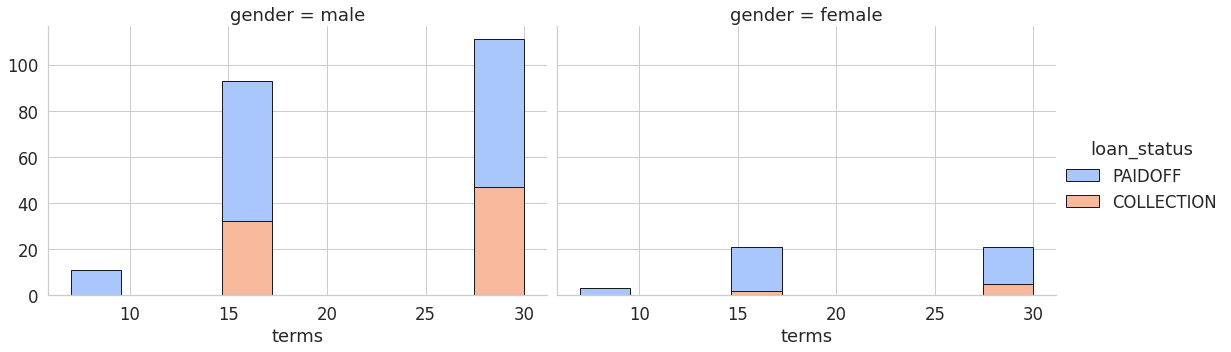

In [17]:
# Let's look at the terms payoff schedule
bins = np.linspace(train_df.terms.min(), train_df.terms.max(), 10)
g = sns.FacetGrid(train_df, col='gender', hue='loan_status', palette='coolwarm', height=5, aspect=1.5)
g.map(plt.hist, 'terms', bins=bins, ec='k')
g.add_legend();

We see that people who have to pay biweekly or monthly may not return their loan, so let's use Feature binarization to set a threshold value less than day 15 days.

In [18]:
train_df['terms'] = np.where(train_df.terms > 7, 1, 0)
test_df['terms'] = np.where(test_df.terms > 7, 1, 0)
train_df.head()

,unnamed_0,loan_status,principal,terms,effective_date,due_date,age,education,gender,dayofweek,weekend
0,0,PAIDOFF,1000,1,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,PAIDOFF,1000,1,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,PAIDOFF,1000,1,2016-09-08,2016-09-22,27,college,male,3,0
3,4,PAIDOFF,1000,1,2016-09-09,2016-10-08,28,college,female,4,1
4,6,PAIDOFF,1000,1,2016-09-09,2016-10-08,29,college,male,4,1


In [19]:
# Let's look at gender
train_df.groupby('gender')\
        .loan_status.value_counts(normalize=True) \
        .to_frame() \
        .rename(columns={'loan_status': 'percentage'}) \
        .reset_index() \
        .pivot(index='gender', columns='loan_status', values='percentage')

loan_status,COLLECTION,PAIDOFF
gender,,
female,0.134615,0.865385
male,0.268707,0.731293


We can see that 86% of female have paied their loans while only 73% of males have paied their loans. However we should consider that in our data there are more samples containg 'male gender' compared to those of 'female gender'.

In [20]:
# Let's look at education
train_df.groupby('education') \
        .loan_status.value_counts(normalize=True) \
        .to_frame() \
        .rename(columns={'loan_status': 'percentage'}) \
        .reset_index() \
        .pivot(index='education', columns='loan_status', values='percentage')

loan_status,COLLECTION,PAIDOFF
education,,
Bechalor,0.250000,0.750000
High School or Below,0.258278,0.741722
Master or Above,0.500000,0.500000
college,0.234899,0.765101


In [21]:
# Let's look at principal
train_df.groupby(['principal', 'loan_status'], as_index=False) \
        .agg({'terms': 'count'}) \
        .rename(columns={'terms': 'number'}) \
        .pivot(index='principal', columns='loan_status', values='number') \
        .fillna(0)

loan_status,COLLECTION,PAIDOFF
principal,,
300,0.0,3.0
500,0.0,2.0
800,18.0,63.0
900,0.0,2.0
1000,68.0,190.0


## Converting Categorical features to numerical values


In [22]:
# Let's convert male to 0 and female to 1
train_df['gender'] = np.where(train_df.gender == 'female', 1, 0)
test_df['gender'] = np.where(test_df.gender == 'female', 1, 0)
train_df.head()

,unnamed_0,loan_status,principal,terms,effective_date,due_date,age,education,gender,dayofweek,weekend
0,0,PAIDOFF,1000,1,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,PAIDOFF,1000,1,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,PAIDOFF,1000,1,2016-09-08,2016-09-22,27,college,0,3,0
3,4,PAIDOFF,1000,1,2016-09-09,2016-10-08,28,college,1,4,1
4,6,PAIDOFF,1000,1,2016-09-09,2016-10-08,29,college,0,4,1


In [23]:
# Let's convert PAIDOFF to 1 and COLLECTION to 0
train_df['loan_status'] = np.where(train_df.loan_status == 'PAIDOFF', 1, 0)
test_df['loan_status'] = np.where(test_df.loan_status == 'PAIDOFF', 1, 0)
train_df.head()

,unnamed_0,loan_status,principal,terms,effective_date,due_date,age,education,gender,dayofweek,weekend
0,0,1,1000,1,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,1,1000,1,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,1,1000,1,2016-09-08,2016-09-22,27,college,0,3,0
3,4,1,1000,1,2016-09-09,2016-10-08,28,college,1,4,1
4,6,1,1000,1,2016-09-09,2016-10-08,29,college,0,4,1


In [24]:
# Let's use one hot encoding technique to conver categorical varables to binary variables and 
# append them to training and testing dataframes
features = ['principal','terms','age','gender', 'weekend']
train = pd.concat([train_df[features], pd.get_dummies(train_df['education'])], axis=1)
test = pd.concat([test_df[features], pd.get_dummies(test_df['education'])], axis=1)
train.head()

,principal,terms,age,gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,1,45,0,0,0,1,0,0
1,1000,1,33,1,0,1,0,0,0
2,1000,1,27,0,0,0,0,0,1
3,1000,1,28,1,1,0,0,0,1
4,1000,1,29,0,1,0,0,0,1


In [25]:
test.head()

,principal,terms,age,gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,1,50,1,0,1,0,0,0
1,300,0,35,0,1,0,0,1,0
2,1000,1,43,1,1,0,1,0,0
3,1000,1,26,0,1,0,0,0,1
4,800,1,29,0,1,1,0,0,0


In [26]:
# Let's rename new columns for convenience
new_columns = {i: i.lower().replace(' ', '_') for i in train.columns}
train.rename(columns=new_columns, inplace=True)
test.rename(columns=new_columns, inplace=True)
train.head()

,principal,terms,age,gender,weekend,bechalor,high_school_or_below,master_or_above,college
0,1000,1,45,0,0,0,1,0,0
1,1000,1,33,1,0,1,0,0,0
2,1000,1,27,0,0,0,0,0,1
3,1000,1,28,1,1,0,0,0,1
4,1000,1,29,0,1,0,0,0,1


## Feature Selection and Data Normalization


In [27]:
# Let's define X and y features sets
X_train = train.copy()
X_test = test.copy()
y_train = train_df['loan_status'].values
y_test = test_df['loan_status'].values

In [28]:
# Let's normalize X features sets
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

In [29]:
# Let's have a look at normalized data
X_train[:4]

array([[ 0.51578458,  0.20535013,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.07624929, -0.86968108],
       [ 0.51578458,  0.20535013,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.07624929, -0.86968108],
       [ 0.51578458,  0.20535013, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.20535013, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679]])

# Classification

## Models used for prediction final results

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

For training and testing models we'll be using **k-Fold Cross-Validation**.

Cross-validation is when the dataset is randomly split up into **k groups**. One of the groups is used as the test set and the rest are used as the training set. The model is trained on the training set and scored on the test set. Then the process is repeated until each unique group as been used as the test set.

For example, for 5-fold cross validation, the dataset would be split into 5 groups, and the model would be trained and tested 5 separate times so each group would get a chance to be the test set.

The train-test-split method we is called 'holdout'. **Cross-validation is better than using the holdout method because the holdout method score is dependent on how the data is split into train and test sets. Cross-validation gives the model an opportunity to test on multiple splits so we can get a better idea on how the model will perform on unseen data.**

## K Nearest Neighbor(KNN)

### Using GridSearchCV for finding the optimal value for 'n_neighbors'

GridSearchCV works by training our model multiple times on a range of parameters that we specify. That way, we can test our model with each parameter and figure out the optimal values to get the best accuracy results.

In [30]:
# Creating a knn model
knn = KNeighborsClassifier()

# Creating a dictionary of all values we want to test for n_neighbors
knn_params = {'n_neighbors': np.arange(1, 25)}

# Using gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, knn_params, cv=5)

# Fitting model to data
knn_gscv.fit(X_train, y_train)

# Let's check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 5}

In [31]:
# Let's create a knn model with the best parameter
knn_cv = KNeighborsClassifier(n_neighbors=7)

# Training the model with cv of 5
grid_knn = cross_val_score(knn_cv, X_train, y_train, cv=5)

# Printing average score accuracy
knn_acc = np.mean(grid_knn).round(2)
print(f'KNN model\'s accuracy mean score: {knn_acc}')

KNN model's accuracy mean score: 0.68


### Prediction and Evaluation

In [32]:
# Train Model and Predict  
knn_model = knn_cv.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_test)

# Let's use required evaluation metrics
knn_j = jaccard_score(y_test, knn_y_pred).round(3)
knn_f1 = f1_score(y_test, knn_y_pred, average='weighted').round(3)

print(f'KNN model Jaccard score: {knn_j}')                   
print(f'KNN model avg F1-score: {knn_f1}')

KNN model Jaccard score: 0.714
KNN model avg F1-score: 0.725


# Decision Tree


In [33]:
# Creating a decision tree model
decision_tree = DecisionTreeClassifier()

# Creating a dictionary of all values we want to test for the decision tree model
tree_params = {'criterion': ['gini','entropy'], 'max_depth': np.arange(1, 51)}

# Using gridsearch to test all values
tree_gscv = GridSearchCV(decision_tree, tree_params, cv=5)

# Fitting model to data. We'll use train set because we don't need normalized data
tree_gscv.fit(train.values, y_train)

# Let's check top performing values
tree_gscv.best_params_

{'criterion': 'gini', 'max_depth': 1}

In [34]:
# Let's create a decision tree model with the best parameters
tree_cv = DecisionTreeClassifier(max_depth=1)

# Training the model with cv of 5. We'll use train set because we don't need normalized data
grid_tree = cross_val_score(tree_cv, train.values, y_train, cv=5)

# Printing average score accuracy
tree_acc = np.mean(grid_tree).round(2)
print(f'Decision tree model\'s accuracy mean score: {tree_acc}')

Decision tree model's accuracy mean score: 0.75


### Prediction and Evaluation

In [35]:
# Train Model and Predict  
tree_model = tree_cv.fit(train.values, y_train)
tree_y_pred = tree_model.predict(test.values)

# Let's use required evaluation metrics
tree_j = jaccard_score(y_test, tree_y_pred).round(3)
tree_f1 = f1_score(y_test, tree_y_pred, average='weighted').round(3)

print(f'Decision Tree model Jaccard score: {tree_j}')                   
print(f'Decision Tree model avg F1-score: {tree_f1}')

Decision Tree model Jaccard score: 0.741
Decision Tree model avg F1-score: 0.63


# Support Vector Machine


In [36]:
# Creating a SVM model
clf = svm.SVC()

# Creating a dictionary of all values we want to test for the SVM model
svm_params = {'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'C': [0.1, 1, 10, 100, 1000]}

# Training the model with cv of 5
svm_gscv = GridSearchCV(clf, svm_params, cv=5)

# Fitting model to data
svm_gscv.fit(X_train, y_train)

# Let's check top performing values
svm_gscv.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

In [37]:
# Let's create a SVM model with the best parameters
clf_cv = svm.SVC(C=0.1, gamma=1, kernel='rbf')

# Training the model with cv of 5
grid_clf = cross_val_score(clf_cv, X_train, y_train, cv=5)

# Printing average score accuracy
clf_acc = np.mean(grid_clf).round(2)
print(f'SVM model\'s accuracy mean score: {clf_acc}')

SVM model's accuracy mean score: 0.75


### Prediction and Evaluation

In [38]:
# Train Model and Predict  
svm_model = clf_cv.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)

# Let's use required evaluation metrics
svm_j = jaccard_score(y_test, svm_y_pred).round(3)
svm_f1 = f1_score(y_test, svm_y_pred, average='weighted').round(3)

print(f'SVM model Jaccard score: {svm_j}')  
print(f'SVM model avg F1-score: {svm_f1}')

SVM model Jaccard score: 0.741
SVM model avg F1-score: 0.63


# Logistic Regression


In [39]:
# Creating a logistic regression model
logreg = LogisticRegression()

# Creating a dictionary of all values we want to test
logreg_params = {'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

# Training the model with cv of 5
logreg_gscv = GridSearchCV(logreg, logreg_params, cv=5)

# Fitting model to data
logreg_gscv.fit(X_train, y_train)

# Let's check top performing values
logreg_gscv.best_params_

{'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}

In [40]:
# Let's create a logistic regression model with the best parameters
logreg_cv = LogisticRegression(C=0.001, penalty='l2', solver='newton-cg')

# Training the model with cv of 5
grid_logreg = cross_val_score(logreg_cv, X_train, y_train, cv=5)

# Printing average score accuracy
logreg_acc = np.mean(grid_logreg).round(2)
print(f'Logistic regression model\'s accuracy mean score: {logreg_acc}')

Logistic regression model's accuracy mean score: 0.75


### Prediction and Evaluation

In [41]:
# Train Model and Predict  
logreg_model = logreg_cv.fit(X_train, y_train)
logreg_y_pred = logreg_model.predict(X_test)

# Let's use required evaluation metrics
logreg_j = jaccard_score(y_test, logreg_y_pred).round(3)
logreg_f1 = f1_score(y_test, logreg_y_pred, average='weighted').round(3)

print(f'Logistic regression model Jaccard score: {logreg_j}')
print(f'Logistic regression model avg F1-score: {logreg_f1}')

Logistic regression model Jaccard score: 0.741
Logistic regression model avg F1-score: 0.63


Now, let's try **log loss** for evaluation. Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1.

In [42]:
yhat_prob = logreg_model.predict_proba(X_test)
logloss_metric = log_loss(y_test, yhat_prob).round(3)
print(f'Logistic regression model log loss score: {logloss_metric}')

Logistic regression model log loss score: 0.561


## Evaluation metrics table

In [43]:
models = pd.DataFrame({
    'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'],
    'Jaccard': [knn_j, tree_j, svm_j, logreg_j],
    'F1-score': [knn_f1, tree_f1, svm_f1, logreg_f1],
    'LogLoss': ['None', 'None', 'None', logloss_metric]})

models

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.714,0.725,None
1,Decision Tree,0.741,0.630,None
2,SVM,0.741,0.630,None
3,Logistic Regression,0.741,0.630,0.561
